
# Ricerca **Non Informata** — BFS, DFS, IDS, Bidirectional BFS, UCS

Obiettivo: implementare e provare i principali algoritmi di **ricerca non informata** su una **griglia** con ostacoli.

**Contenuti**
- Breadth‑First Search (BFS) — *uniform cost in passi*
- Depth‑First Search (DFS) — con limite opzionale di profondità
- Iterative Deepening Search (IDS) — con routine DLS ausiliaria
- Bidirectional BFS — BFS da **Start** e **Goal** che si incontrano
- Uniform Cost Search (UCS) — espande il nodo con **minimo costo `g(n)`**

Saranno mostrati:
- **Percorsi** trovati su una griglia 10×10 con ostacoli
- **Metriche**: nodi espansi, dimensione massima della frontiera, costo (in **passi**)
- Un secondo scenario con **costi variabili** per evidenziare le differenze con **UCS**


## Setup e utility

In [1]:
import os; os.environ.setdefault("MPLBACKEND", "Agg")

from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Callable, Iterable, Set
from collections import deque
import heapq
import math

import matplotlib.pyplot as plt

Coord = Tuple[int, int]

@dataclass
class SearchResult:
    path: List[Coord]
    cost: float
    expanded: int
    max_frontier: int
    found: bool
    name: str

def reconstruct_path(came_from: Dict[Coord, Optional[Coord]], start: Coord, goal: Coord) -> List[Coord]:
    if goal not in came_from:
        return []
    cur = goal
    out = [cur]
    while cur != start:
        cur = came_from[cur]
        if cur is None:
            return []
        out.append(cur)
    out.reverse()
    return out

class Grid:
    def __init__(self, rows: int, cols: int, walls: Set[Coord] | None = None, cost_fn: Optional[Callable[[Coord], float]] = None):
        self.rows, self.cols = rows, cols
        self.walls = walls or set()
        self.cost_fn = cost_fn or (lambda _: 1.0)

    def in_bounds(self, s: Coord) -> bool:
        r, c = s
        return 0 <= r < self.rows and 0 <= c < self.cols

    def passable(self, s: Coord) -> bool:
        return s not in self.walls

    def neighbors(self, s: Coord) -> Iterable[Coord]:
        r, c = s
        for dr, dc in [(-1,0),(0,1),(1,0),(0,-1)]:
            t = (r+dr, c+dc)
            if self.in_bounds(t) and self.passable(t):
                yield t

    def step_cost(self, s: Coord, t: Coord) -> float:
        # costo associato alla cella di arrivo
        return float(self.cost_fn(t))

def plot_grid(grid: Grid, start: Coord, goal: Coord, path: List[Coord] | None = None, title: str = ""):
    # Una figura per chiamata, nessun colore forzato
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(-0.5, grid.cols-0.5)
    ax.set_ylim(-0.5, grid.rows-0.5)
    ax.set_xticks(range(grid.cols))
    ax.set_yticks(range(grid.rows))
    ax.grid(True)

    for (r,c) in grid.walls:
        ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, alpha=0.5))

    if path:
        xs = [c for r,c in path]
        ys = [r for r,c in path]
        ax.plot(xs, ys, linewidth=2, marker="o")

    ax.text(start[1], start[0], "S", ha="center", va="center", fontsize=12)
    ax.text(goal[1], goal[0], "G", ha="center", va="center", fontsize=12)
    ax.set_title(title)
    plt.show()

def path_weighted_cost(grid: Grid, path: List[Coord]) -> float:
    if not path or len(path) < 2: 
        return 0.0 if path else math.inf
    total = 0.0
    for a,b in zip(path[:-1], path[1:]):
        total += grid.step_cost(a,b)
    return total


## Algoritmi di ricerca non informata


### Breadth‑First Search (BFS) — *uniform cost in passi*
- Espande i nodi **per livelli** (orizzontalmente).
- **Completo** su grafi finiti; **ottimo in numero di passi** con costi unitari.
- **Memoria** elevata: con ramificazione `r` e profondità `d` ~ `O(r^d)` nodi.


In [2]:
def bfs(grid: Grid, start: Coord, goal: Coord) -> SearchResult:
    frontier = deque([start])
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    expanded = 0
    max_frontier = 1
    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        s = frontier.popleft()
        expanded += 1
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            return SearchResult(path, cost=len(path)-1 if path else float('inf'), expanded=expanded, max_frontier=max_frontier, found=bool(path), name="BFS")
        for t in grid.neighbors(s):
            if t not in came_from:
                came_from[t] = s
                frontier.append(t)
    return SearchResult([], float('inf'), expanded, max_frontier, False, "BFS")



### Depth‑First Search (DFS)
- Espande **prima** il nodo più profondo.
- **Memoria** inferiore rispetto a BFS (traccia lo stack del path).
- **Non completo** in spazi con profondità infinita o con cicli (senza cutoff); **completo** su spazi finiti.
- **Non ottimo**.


In [3]:
def dfs(grid: Grid, start: Coord, goal: Coord, depth_limit: Optional[int]=None) -> SearchResult:
    stack = [start]
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    expanded = 0
    max_frontier = 1
    depth: Dict[Coord, int] = {start: 0}
    while stack:
        max_frontier = max(max_frontier, len(stack))
        s = stack.pop()
        expanded += 1
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            return SearchResult(path, cost=len(path)-1 if path else float('inf'), expanded=expanded, max_frontier=max_frontier, found=bool(path), name="DFS")
        if depth_limit is not None and depth[s] >= depth_limit:
            continue
        for t in grid.neighbors(s):
            if t not in came_from:
                came_from[t] = s
                depth[t] = depth[s] + 1
                stack.append(t)
    return SearchResult([], float('inf'), expanded, max_frontier, False, "DFS")



### Iterative Deepening Search (IDS)
- Combina i vantaggi di BFS (soluzione a profondità minima) e DFS (bassa memoria).
- Esegue **DLS** (Depth‑Limited Search) con limiti 0,1,2,… finché trova una soluzione.
- **Completo** su grafi finiti; **ottimo in passi** con costi unitari; **memoria** `O(b·d)`.


In [4]:
def _dls(grid: Grid, start: Coord, goal: Coord, depth_limit: int):
    """Depth-Limited Search iterativa (tree-search). Ritorna (found, came_from, expanded, max_frontier)."""
    stack = [(start, 0, None)]  # (stato, profondità, padre)
    came_from: Dict[Coord, Optional[Coord]] = {}
    expanded = 0
    max_frontier = 1
    onpath_count: Dict[Coord, int] = {}

    while stack:
        max_frontier = max(max_frontier, len(stack))
        s, d, parent = stack.pop()

        onpath_count[s] = onpath_count.get(s, 0) + 1
        if parent is not None and s not in came_from:
            came_from[s] = parent
        elif s == start:
            came_from.setdefault(s, None)

        expanded += 1
        if s == goal:
            return True, came_from, expanded, max_frontier

        if d < depth_limit:
            nbrs = list(grid.neighbors(s))
            for t in reversed(nbrs):  # DFS LIFO
                if onpath_count.get(t, 0) == 0:
                    stack.append((t, d+1, s))

        onpath_count[s] -= 1
        if onpath_count[s] == 0:
            del onpath_count[s]

    return False, came_from, expanded, max_frontier


def ids(grid: Grid, start: Coord, goal: Coord, max_depth_limit: Optional[int] = None) -> SearchResult:
    """Iterative Deepening Search (IDS) con conteggio aggregato delle espansioni."""
    if max_depth_limit is None:
        max_depth_limit = grid.rows * grid.cols - 1

    total_expanded = 0
    overall_max_frontier = 0
    best_came_from: Dict[Coord, Optional[Coord]] = {}

    for depth_limit in range(max_depth_limit + 1):
        found, came_from, expanded, max_frontier = _dls(grid, start, goal, depth_limit)
        total_expanded += expanded
        overall_max_frontier = max(overall_max_frontier, max_frontier)
        best_came_from = came_from

        if found:
            path = reconstruct_path(best_came_from, start, goal)
            return SearchResult(path=path, cost=len(path)-1 if path else float("inf"),
                                expanded=total_expanded, max_frontier=overall_max_frontier,
                                found=True, name="IDS")

    return SearchResult(path=[], cost=float("inf"), expanded=total_expanded,
                        max_frontier=overall_max_frontier, found=False, name="IDS")



### Bidirectional Search (BFS‑BFS)
- Due ricerche **BFS**: una da **Start**, una da **Goal**.
- Quando le frontiere si incontrano, si ricostruisce il cammino.
- **Ottima in passi** con costi unitari; spesso riduce espansioni da `O(b^d)` a `O(b^{d/2})`.


In [5]:
def bidirectional_bfs(grid: Grid, start: Coord, goal: Coord) -> SearchResult:
    if start == goal:
        return SearchResult(path=[start], cost=0.0, expanded=0, max_frontier=1, found=True, name="BiBFS")
    if not grid.passable(start) or not grid.passable(goal):
        return SearchResult(path=[], cost=float("inf"), expanded=0, max_frontier=0, found=False, name="BiBFS")

    frontier_fwd = deque([start])
    frontier_bwd = deque([goal])
    came_from_fwd: Dict[Coord, Optional[Coord]] = {start: None}
    came_from_bwd: Dict[Coord, Optional[Coord]] = {goal: None}

    expanded_total = 0
    max_frontier = len(frontier_fwd) + len(frontier_bwd)

    def _expand(frontier: deque, came_from_this: Dict[Coord, Optional[Coord]], came_from_other: Dict[Coord, Optional[Coord]]):
        if not frontier:
            return None, 0
        s = frontier.popleft()
        expanded = 1
        for t in grid.neighbors(s):
            if t not in came_from_this:
                came_from_this[t] = s
                if t in came_from_other:
                    return t, expanded
                frontier.append(t)
        return None, expanded

    while frontier_fwd and frontier_bwd:
        max_frontier = max(max_frontier, len(frontier_fwd) + len(frontier_bwd))
        if len(frontier_fwd) <= len(frontier_bwd):
            meet, exp = _expand(frontier_fwd, came_from_fwd, came_from_bwd)
        else:
            meet, exp = _expand(frontier_bwd, came_from_bwd, came_from_fwd)
        expanded_total += exp

        if meet is not None:
            path_start_to_meet = reconstruct_path(came_from_fwd, start, meet)
            path_goal_to_meet  = reconstruct_path(came_from_bwd, goal, meet)
            if not path_start_to_meet or not path_goal_to_meet:
                return SearchResult([], float("inf"), expanded_total, max_frontier, False, "BiBFS")
            tail_meet_to_goal = list(reversed(path_goal_to_meet))
            full_path = path_start_to_meet + tail_meet_to_goal[1:]
            return SearchResult(path=full_path, cost=len(full_path)-1, expanded=expanded_total, max_frontier=max_frontier, found=True, name="BiBFS")

    return SearchResult([], float("inf"), expanded_total, max_frontier, False, "BiBFS")



### Uniform Cost Search (UCS)
- Variante di **Dijkstra**: espande il nodo con **minimo `g(n)`**.
- Con costi unitari è equivalente a **BFS**; con costi variabili è **ottimo** (se costi non negativi).
- **Memoria** potenzialmente elevata (mantiene la frontiera ordinata).


In [6]:
def ucs(grid: Grid, start: Coord, goal: Coord) -> SearchResult:
    frontier: List[Tuple[float, Coord]] = [(0.0, start)]
    came_from: Dict[Coord, Optional[Coord]] = {start: None}
    g: Dict[Coord, float] = {start: 0.0}
    expanded = 0
    max_frontier = 1
    while frontier:
        max_frontier = max(max_frontier, len(frontier))
        cost_s, s = heapq.heappop(frontier)
        if s == goal:
            path = reconstruct_path(came_from, start, goal)
            return SearchResult(path, cost=g[s], expanded=expanded, max_frontier=max_frontier, found=True, name="UCS")
        expanded += 1
        for t in grid.neighbors(s):
            new_cost = g[s] + grid.step_cost(s, t)
            if t not in g or new_cost < g[t]:
                g[t] = new_cost
                came_from[t] = s
                heapq.heappush(frontier, (new_cost, t))
    return SearchResult([], float('inf'), expanded, max_frontier, False, "UCS")


## Esperimenti su griglia 10×10 con ostacoli — Costi **uniformi**

BFS      | found=True | steps=18 | expanded=86 | max_frontier=9
DFS      | found=True | steps=18 | expanded=19 | max_frontier=16
IDS      | found=True | steps=18 | expanded=292284151 | max_frontier=34
BiBFS    | found=True | steps=18 | expanded=66 | max_frontier=17
UCS      | found=True | steps=18 | expanded=85 | max_frontier=9


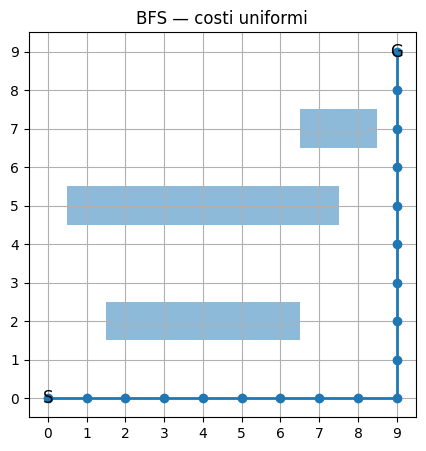

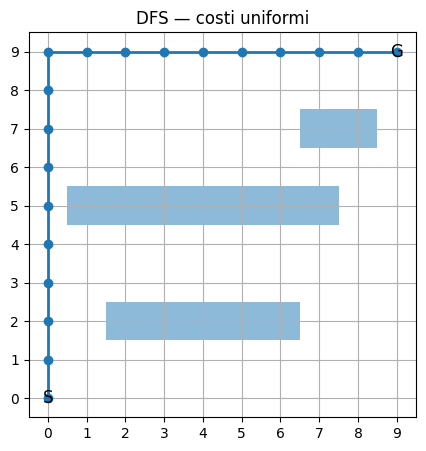

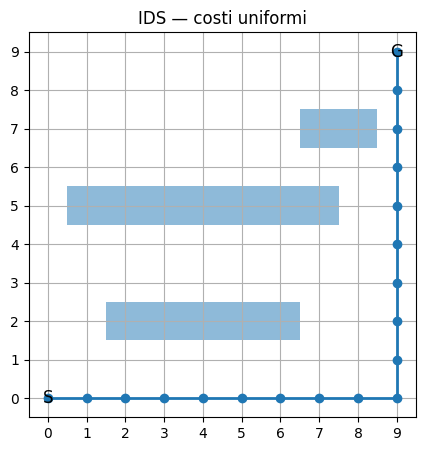

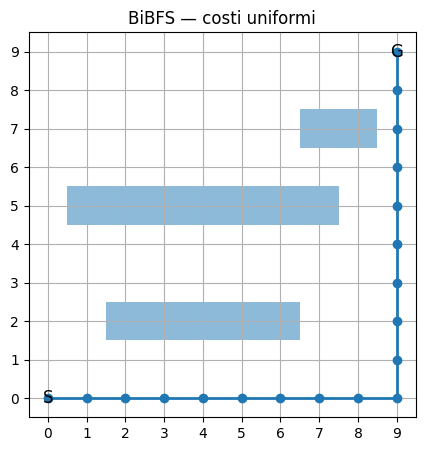

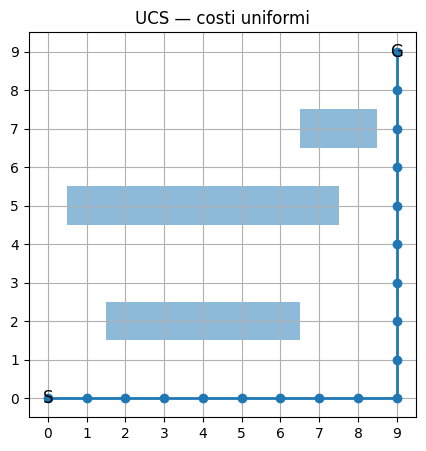

In [7]:
# Definizione griglia di test
rows, cols = 10, 10
walls = {
    (2,2),(2,3),(2,4),(2,5),(2,6),
    (5,1),(5,2),(5,3),(5,4),(5,5),(5,6),(5,7),
    (7,7),(7,8)
}
grid = Grid(rows, cols, walls=walls)
start, goal = (0,0), (9,9)

res_bfs = bfs(grid, start, goal)
res_dfs = dfs(grid, start, goal)
res_ids = ids(grid, start, goal)
res_bibfs = bidirectional_bfs(grid, start, goal)
res_ucs = ucs(grid, start, goal)

results = [res_bfs, res_dfs, res_ids, res_bibfs, res_ucs]

for r in results:
    print(f"{r.name:8s} | found={r.found} | steps={r.cost:.0f} | expanded={r.expanded} | max_frontier={r.max_frontier}")

# Visualizza percorsi
for r in results:
    plot_grid(grid, start, goal, r.path, title=f"{r.name} — costi uniformi")


## Scenario con **costi variabili** — confronto con UCS

BFS      | found=True | steps=18 | weighted_cost=18.0 | expanded=86 | max_frontier=9
DFS      | found=True | steps=18 | weighted_cost=18.0 | expanded=19 | max_frontier=16
IDS      | found=True | steps=18 | weighted_cost=18.0 | expanded=292284151 | max_frontier=34
BiBFS    | found=True | steps=18 | weighted_cost=18.0 | expanded=66 | max_frontier=17
UCS      | found=True | steps=18 | weighted_cost=18.0 | expanded=84 | max_frontier=12


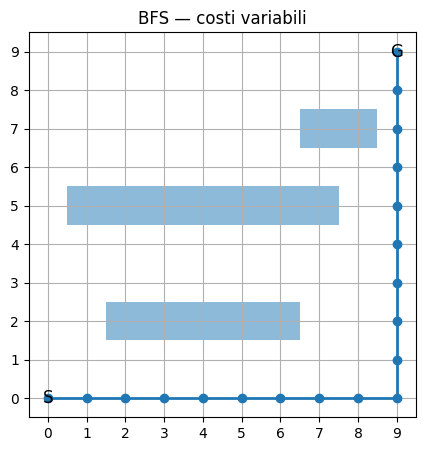

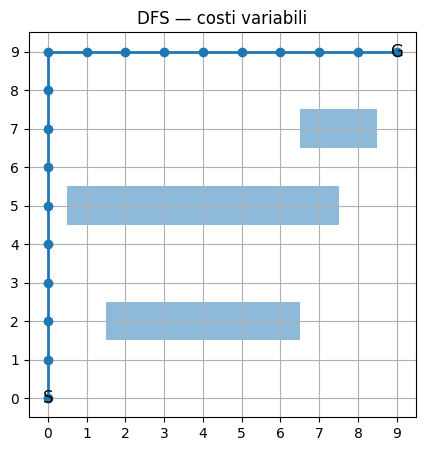

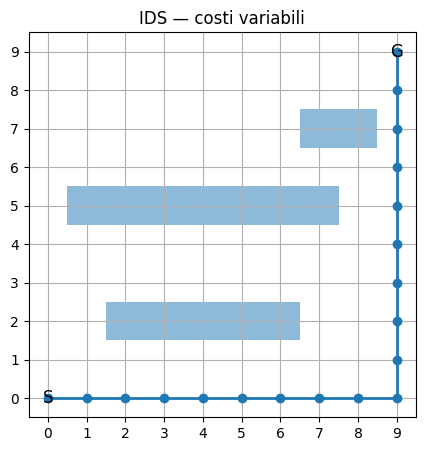

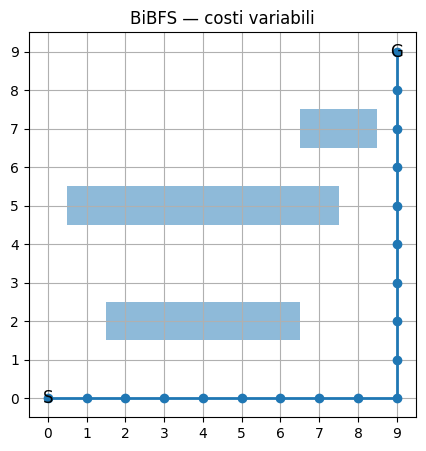

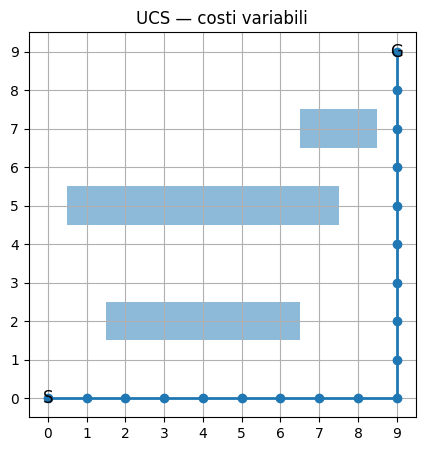

In [8]:

# Celle 'costose' (peso 5 invece di 1)
penalty_cells = {(3,3),(3,4),(3,5),(4,5),(6,2),(6,3),(6,4),(7,4),(8,4)}
grid_w = Grid(rows, cols, walls=walls, cost_fn=lambda cell: 5.0 if cell in penalty_cells else 1.0)

res_bfs_w = bfs(grid_w, start, goal)          # ignora pesi -> costo in passi
res_dfs_w = dfs(grid_w, start, goal)          # idem
res_ids_w = ids(grid_w, start, goal)          # idem
res_bibfs_w = bidirectional_bfs(grid_w, start, goal)  # idem
res_ucs_w = ucs(grid_w, start, goal)          # ottimo sul costo pesato

results_w = [res_bfs_w, res_dfs_w, res_ids_w, res_bibfs_w, res_ucs_w]

for r in results_w:
    wcost = path_weighted_cost(grid_w, r.path)
    print(f"{r.name:8s} | found={r.found} | steps={r.cost:.0f} | weighted_cost={wcost:.1f} | expanded={r.expanded} | max_frontier={r.max_frontier}")

for r in results_w:
    plot_grid(grid_w, start, goal, r.path, title=f"{r.name} — costi variabili")
